In [27]:
import pathlib
import tensorflow as tf

## Download the dataset provided by Anki, https://www.manythings.org/anki/
Using the keras library, we download the text file representing the dataset

In [28]:
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)

In [29]:
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

/Users/adeyemialadesawe/.keras/datasets/fra.txt


## Normalize the strings

In [30]:
import pickle
import random
import re
import unicodedata

import tensorflow as tf

def normalize(line):
    """
    Normalize a line of text and split into two at the etab character.
    Each word should be a separate token as well as each punctuation mark.
    However, the punctuation used in contractions such as don’t, va-t-il,or c’est are not separated from the words.
    Algo:
    use the Python module unicodedata to convert a Unicode string into NFKC normal form.
    Then you will use regular expression to add space around punctuation marks.
    Afterward, you will wrap the French sentences (i.e., the target language) with sentinels [start] and [end].
    """
    line = unicodedata.normalize("NFKC",  line.strip().lower())
    b4 = line
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    try:
        eng, fra = line.split("\t")
    except Exception as e:
        print(f"{e} raised \n")
        print(f"before: '{b4}' \n after: '{line}'.")
    fra = "[start] " + fra + " [end]"
    return eng, fra

In [33]:
line = """"I forgot," she said.	"J'ai oublié", répondit-elle."""
eng, fra = normalize(line)
print(f'`{eng}`')
print(f'`{fra}`')

` " i forgot, " she said .`
`[start]  " j'ai oublié" , répondit-elle . [end]`


In [34]:
# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

In [35]:
# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

('there were no other survivors .', "[start] il n'y avait pas d'autres survivants . [end]")
("let's try something .", '[start] tentons quelque chose  !  [end]')
("something happened here , but i don't know what .", "[start] quelque chose s'est produit ici , mais j'ignore quoi . [end]")
('could i borrow a saw ?', '[start] pourrais-je emprunter une scie  ?  [end]')
("i'm here to talk about tom .", '[start] je suis ici pour parler de tom . [end]')


In [36]:
with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

## Explore the token statistics in each language

In [37]:
import pickle

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)

print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


## Historgram to show distribution of the tokens

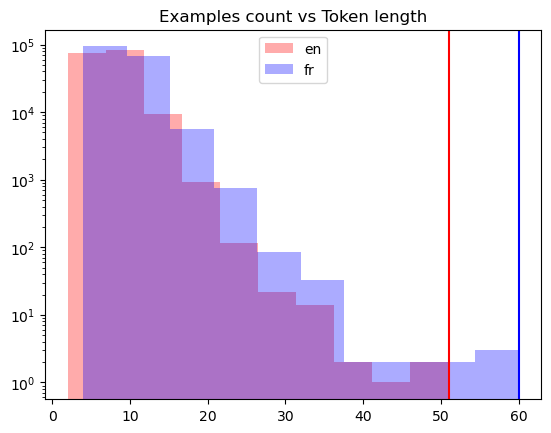

In [38]:
import pickle
import matplotlib.pyplot as plt

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, _ in text_pairs]
fr_lengths = [len(fra.split()) for _, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")   # sentence length fits Benford's law
plt.ylim(plt.ylim())    # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()